In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from tqdm import tqdm

import keras
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from IPython.display import clear_output
import pickle
from datetime import datetime
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Trabajo/Airline'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
DATASET_FILES = [
  '/content/drive/My Drive/WX6040.csv'
]

In [ ]:
MONTHS = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

def encoding_month(month):
  return MONTHS.index(month) + 1

def encoding_hour(hour):
  hour_nums = hour.split(':')
  assert(len(hour_nums) == 3)
  nhour = int(hour_nums[0]) + (int(hour_nums[1]) / 60) + (int(hour_nums[2]) / 3600)
  return nhour

def encoding_day(date):
    for fmt in ('%Y-%m-%d %M:%S:%f', '%d/%m/%Y %H:%M', '%d/%m/%Y'):
        try:
            return datetime.strptime(date, fmt).day
        except ValueError:
            pass
    raise ValueError('No valid date format found: {}'.format(date))
  

In [ ]:
def sequences(a, width=3, offset=0, limit=0):
    n = a.shape[0]
    result = []
    for i in range(offset, n - width + limit):
      result.append(a[i: i+width])
      
    return np.asarray(result)

In [ ]:
FEATURES = 7
SAMPLES = 24
PREDICTIONS = 8

In [ ]:
x_data = None
y_data = None

for idx, dataset_file in enumerate(DATASET_FILES):
  
  print('----------------------------------------------------------------')
  print('Iteration {} File {}'.format(idx, dataset_file))
  
  df = pd.read_csv(dataset_file)
  df = df[['DATE', 'ANIO', 'MES', 'HORA','VISIBILIDAD', 'GRADOS', 'INTENSIDAD', 'TEMPERATURA', 'PUNTO_ROCIO', 'CLOSED']]
  df['MES_ENC'] = df['MES'].apply(lambda x: encoding_month(x))
  df['DIA_ENC'] = df['DATE'].apply(lambda x: encoding_day(x))
  df['HORA_ENC'] = df['HORA'].apply(lambda x: encoding_hour(x))

  # [['MES_ENC', 'DIA_ENC', 'HORA_ENC', 'GRADOS', 'INTENSIDAD', 'TEMPERATURA', 'PUNTO_ROCIO', 'VISIBILIDAD']] \
  df = df.sort_values(by=['ANIO', 'MES_ENC', 'DIA_ENC', 'HORA_ENC'], ascending=True) \
            [['MES_ENC', 'HORA_ENC','VISIBILIDAD',  'GRADOS', 'INTENSIDAD','TEMPERATURA', 'PUNTO_ROCIO', 'CLOSED']] \
            .interpolate()


  x = df.drop(['CLOSED'], axis=1)
  y = df[['CLOSED']]

  x = x.values
  y = y.values

  print('X-Shape:{} \t Y-Shape:{}'.format(x.shape, y.shape))

  y_nan_indices = np.argwhere(np.isnan(y))
  print('File {}     Y     Nan {}'.format(idx, y_nan_indices.shape))
  
  for i in range(FEATURES):
    x_nan_indices = np.argwhere(np.isnan(x[:, i]))
    print('File {}     Feature {}    Nan {}'.format(idx, i, x_nan_indices.shape))



  if x_data is None:
    x_data = sequences(x, width=SAMPLES, limit=-PREDICTIONS)
    y_data = sequences(y, offset=SAMPLES, width=PREDICTIONS)
  else:
    x_data = np.concatenate([x_data, sequences(x, width=SAMPLES, limit=-PREDICTIONS)], axis=0)
    y_data = np.concatenate([y_data, sequences(y, offset=SAMPLES, width=PREDICTIONS)], axis=0)

#y_data = y_data.reshape(y_data.shape[0], 1)
print('----------------------------------------------------------------')
print('Total')
print('X-Shape:{} \t Y-Shape:{}'.format(x_data.shape, y_data.shape))



----------------------------------------------------------------
Iteration 0 File /content/drive/My Drive/WX6040.csv
X-Shape:(27497, 7) 	 Y-Shape:(27497, 1)
File 0     Y     Nan (0, 2)
File 0     Feature 0    Nan (0, 1)
File 0     Feature 1    Nan (0, 1)
File 0     Feature 2    Nan (0, 1)
File 0     Feature 3    Nan (0, 1)
File 0     Feature 4    Nan (0, 1)
File 0     Feature 5    Nan (0, 1)
File 0     Feature 6    Nan (0, 1)
----------------------------------------------------------------
Total
X-Shape:(27465, 24, 7) 	 Y-Shape:(27465, 8, 1)


In [ ]:
df.head()

,MES_ENC,HORA_ENC,VISIBILIDAD,GRADOS,INTENSIDAD,TEMPERATURA,PUNTO_ROCIO,CLOSED
0,1,11.0,0.50,180,4,19,19,1
1,1,12.0,0.50,170,4,19,19,1
2,1,13.0,0.37,150,4,19,19,1
3,1,14.0,0.62,160,6,19,19,1
4,1,11.0,0.00,0,0,19,19,1


In [ ]:
def get_model():

    x = keras.layers.Input(shape=(SAMPLES, FEATURES))
    
    out = x

    out = keras.layers.GRU(512,
                           activation='relu',
                           dropout=0.2, 
                           recurrent_dropout=0.1,
                           return_sequences=True
                           #kernel_regularizer=keras.regularizers.l2(0.01), 
                           #recurrent_regularizer=keras.regularizers.l2(0.01), 
                           #bias_regularizer=keras.regularizers.l2(0.01)
                          )(out)

    out = keras.layers.Lambda(lambda x: x[:, -PREDICTIONS:])(out)

    out = keras.layers.TimeDistributed(keras.layers.Dense(128))(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Dropout(0.2)(out)
    
    out = keras.layers.Dense(64)(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Dropout(0.1)(out)
    
    out = keras.layers.Dense(16)(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.ReLU()(out)
    
    out = keras.layers.Dense(1)(out)
    out = keras.layers.Activation('sigmoid')(out)
    
    model = keras.models.Model(inputs=[x], outputs=[out])
    
    return model

In [ ]:
model = get_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 24, 7)             0         
_________________________________________________________________
gru_3 (GRU)                  (None, 24, 512)           798720    
_________________________________________________________________
lambda_3 (Lambda)            (None, 8, 512)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 8, 128)            65664     
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 128)            512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 8, 128)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 128)            0   

In [ ]:
LEARNING_RATE = 1e-3
EARLY_STOPPING_LIMIT = 60
LR_REDUCE_LIMIT = 40
EPOCHS = 500
BATCH_SIZE = 1024
TEST_SIZE = 0.2
DEV_SIZE = 0.2

MODEL_FILE = 'closed_model.h5'

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE, random_state=42)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=DEV_SIZE, random_state=42)

In [ ]:
def reshape(x, oshape):
  return x.reshape((oshape[0] * oshape[1], oshape[2]))

def ireshape(x, oshape):
  return x.reshape(oshape)

otshape = x_train.shape
odshape = x_dev.shape
ottshape = x_test.shape

scaler = StandardScaler()
scaler.fit(reshape(x_train, otshape))

with open('closed.scaler', 'wb') as visibility_file:
  pickle.dump(scaler, visibility_file)

x_train = ireshape(scaler.transform(reshape(x_train, otshape)), otshape)
x_test = ireshape(scaler.transform(reshape(x_test, ottshape)), ottshape)
x_dev = ireshape(scaler.transform(reshape(x_dev, odshape)), odshape)

In [ ]:
model = get_model()
loss_fn = keras.losses.binary_crossentropy
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, amsgrad=True)

model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=EARLY_STOPPING_LIMIT, 
    min_delta=1e-4, 
    restore_best_weights=True, 
    monitor='val_loss',
    mode='min'
)

stop_nan = keras.callbacks.TerminateOnNaN()

save_weights = keras.callbacks.ModelCheckpoint(
    MODEL_FILE, 
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=LR_REDUCE_LIMIT, 
    verbose=1,
    min_delta=1e-4, 
    mode='min'
)

history = model.fit(
    x_train, 
    y_train,
    epochs=EPOCHS, 
    callbacks=[early_stopping, stop_nan, save_weights, reduce_lr_loss], 
    validation_data=[x_dev, y_dev], 
    batch_size=BATCH_SIZE
)
    

Train on 17577 samples, validate on 4395 samples
Epoch 1/500
17577/17577 [==============================] - 2s 142us/step - loss: 0.6705 - accuracy: 0.6084 - val_loss: 0.6764 - val_accuracy: 0.6301
Epoch 2/500
17577/17577 [==============================] - 2s 93us/step - loss: 0.6376 - accuracy: 0.6391 - val_loss: 0.6663 - val_accuracy: 0.6113
Epoch 3/500
17577/17577 [==============================] - 2s 94us/step - loss: 0.6306 - accuracy: 0.6451 - val_loss: 0.6585 - val_accuracy: 0.6093
Epoch 4/500
17577/17577 [==============================] - 2s 90us/step - loss: 0.6283 - accuracy: 0.6462 - val_loss: 0.6576 - val_accuracy: 0.6076
Epoch 5/500
17577/17577 [==============================] - 2s 93us/step - loss: 0.6257 - accuracy: 0.6510 - val_loss: 0.6579 - val_accuracy: 0.6064
Epoch 6/500
17577/17577 [==============================] - 2s 92us/step - loss: 0.6256 - accuracy: 0.6494 - val_loss: 0.6545 - val_accuracy: 0.6049
Epoch 7/500
17577/17577 [==============================] - 2s 

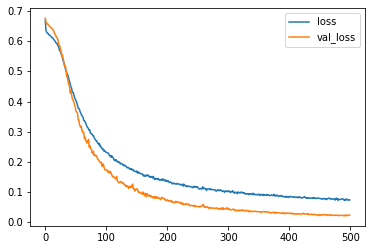

In [ ]:
tr_epochs = len(history.history['loss'])

plt.plot(range(tr_epochs), history.history['loss'], label="loss")
plt.plot(range(tr_epochs), history.history['val_loss'], label="val_loss")
plt.legend()
plt.show();

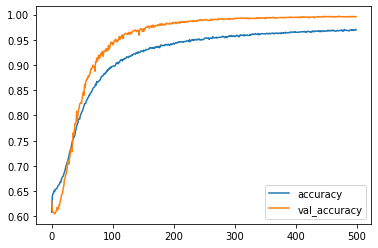

In [ ]:
tr_epochs = len(history.history['accuracy'])

plt.plot(range(tr_epochs), history.history['accuracy'], label="accuracy")
plt.plot(range(tr_epochs), history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show();

In [ ]:
argmax_acc = np.argmax(history.history['val_accuracy'])
print('Val loss:{}\tVal acc:{}'.format(history.history['val_loss'][argmax_acc], history.history['val_accuracy'][argmax_acc]))

Val loss:0.022005667675612864	Val acc:0.9967292547225952


In [ ]:
model = keras.models.load_model(
    MODEL_FILE, 
    custom_objects={
        'PREDICTIONS': PREDICTIONS
      }
    )

In [ ]:
y_pred = model.predict(x_test)

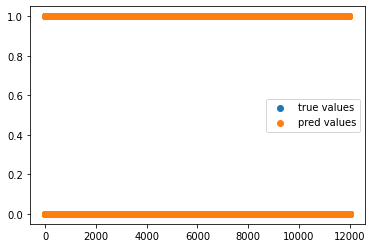

In [ ]:
assert(y_pred.shape == y_test.shape)

y_test_ = y_test[:1500]
y_pred_ = y_pred[:1500]

plt.scatter([i for i in range(y_test_.shape[0] * y_test_.shape[1])], y_test_.flatten(), label="true values")
plt.scatter([i for i in range(y_pred_.shape[0] * y_pred_.shape[1])], np.round(y_pred_.flatten()), label="pred values")
plt.legend()
plt.show();

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test.flatten(), np.round(y_pred.flatten()), labels=[0, 1]).ravel()
print('True negatives:{}\tFalse positives:{}\tFalse negatives:{}\tTrue positive:{}'.format(tn, fp, fn, tp))
print('Accuracy:{}'.format((tn + tp) / (tn + fp + fn + tp)))

True negatives:26180	False positives:74	False negatives:89	True positive:17601
Accuracy:0.9962907336610232


In [ ]:
print('Precision CLOSED:{}'.format(tp/(tp+fp)))
print('Recall CLOSED:{}'.format(tp/(tp+fn)))

Precision CLOSED:0.9958132956152758
Recall CLOSED:0.9949689089881288
